In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import scipy.stats as st
import xgboost as xgb
import random as rd
import csv
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
#pd.option.display.max_rows = 1000
#pd.option.display.max_coloums = 20

In [2]:
!git clone https://github.com/Jun-629/DS502.git
!ls -R

0套极简风PPT模板
hw1.pdf
hw2Hint.pdf
i-765.pdf
ich6.pdf
incr-0.2.zsh
integration.R
lec6.pdf
ma_556_proj.pdf
mle.R
optimization.R
reservationical.ics
rmdma543.Rmd
rmdma543.pdf
rourou.Rmd
rrshare
sa-varsel.R
tetris_game-master
truncated_normal.pdf
wei.pdf
weiwei_comments.pdf
wordtex
~$dma543.docx
万梓畅 UMich I-20.pdf
备注 2023.pdf
实变函数
旧金山.pdf
洛杉矶.pdf
签证材料包裹
统计推断(Statistical-Inference)第二版-练习题-答案.pdf

./BaiduExporter-master:
BaiduExporter.crx README.md         chrome
LICENSE           aria2c

./BaiduExporter-master/aria2c:
HideRun.vbs README.md   aria2.conf  start.bat

./BaiduExporter-master/chrome:
_locales          manifest.json     release
background.js     package-lock.json src
gulpfile.js       package.json      updates.xml

./BaiduExporter-master/chrome/_locales:
en    zh_CN

./BaiduExporter-master/chrome/_locales/en:
messages.json

./BaiduExporter-master/chrome/_locales/zh_CN:
messages.json

./BaiduExporter-master/chrome/release:
_locales      css           js
background.js img           man

In [3]:
data0 = pd.read_csv('./DS502/Project/train.csv')

Id = data0['Id']          # Save the 'Id' column before drop it
SalePrice = data0.SalePrice    # Save the 'SalePrice' column before drop it
data = data0.drop(['Id','SalePrice'], axis = 1)  # the data set with only factors we may need

- Visualize the features in the dataset.

In [4]:
# Finding numeric features

numeric_dtypes = ['int64', 'float64']
numeric = []
for i in data.columns:
  if data[i].dtype in numeric_dtypes:
    #if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
      #pass
    #else:
    numeric.append(i)
print(numeric)          # The numeric variables with 36 terms

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [5]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(len(missing_data))

Missing Ratio
PoolQC            99.520548
MiscFeature       96.301370
Alley             93.767123
Fence             80.753425
FireplaceQu       47.260274
LotFrontage       17.739726
GarageYrBlt        5.547945
GarageType         5.547945
GarageFinish       5.547945
GarageQual         5.547945
GarageCond         5.547945
BsmtFinType2       2.602740
BsmtExposure       2.602740
BsmtFinType1       2.534247
BsmtCond           2.534247
BsmtQual           2.534247
MasVnrArea         0.547945
MasVnrType         0.547945
Electrical         0.068493

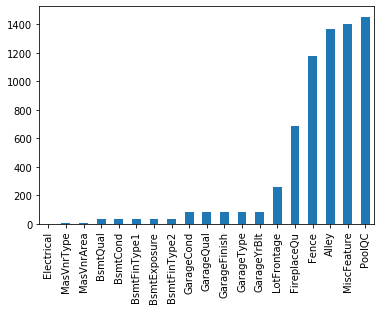

In [6]:
numerical = [f for f in data0.columns if data0.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
qualitative = [f for f in data0.columns if data0.dtypes[f] == 'object']

missing = data0.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()



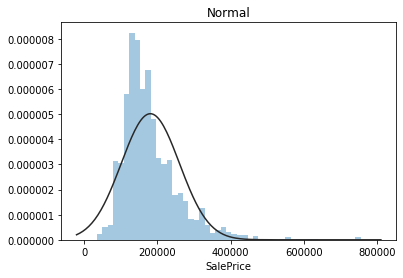

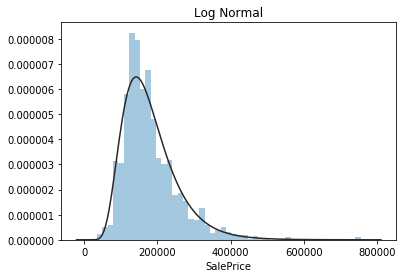

In [7]:
y = data0['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

It seems that **SalePrice** does not follow the normal distribution, so we may use *Box Cox* transformation to fit this variable.

In [39]:
f = pd.melt(data0, value_vars=numerical)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.

***Dealing with Categorical data***

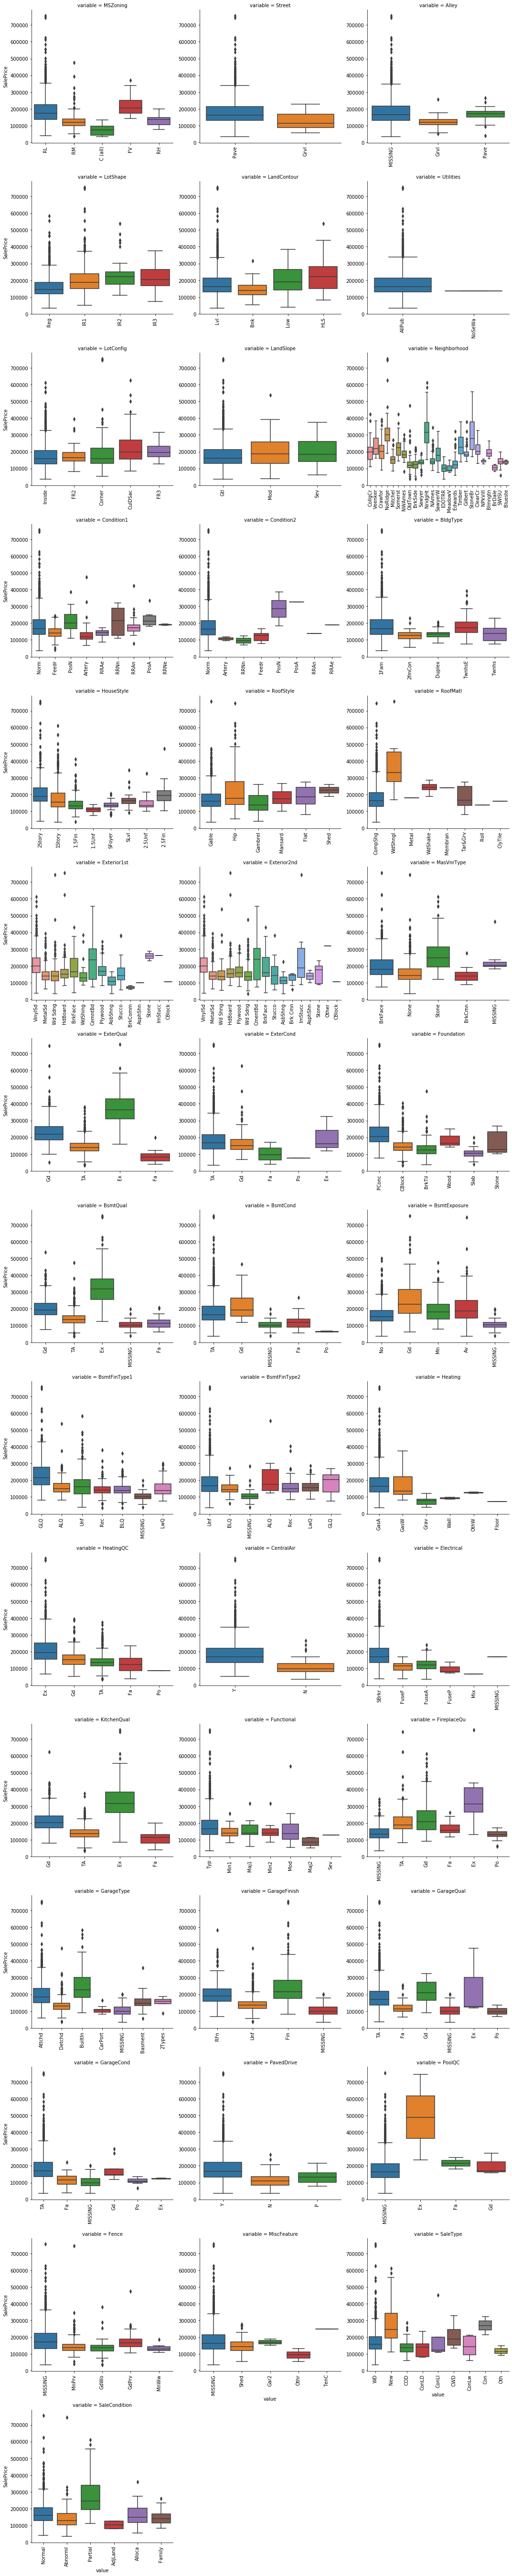

In [9]:
for c in qualitative:
    data0[c] = data0[c].astype('category')
    if data0[c].isnull().any():
        data0[c] = data0[c].cat.add_categories(['MISSING'])
        data0[c] = data0[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(data0, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Some ***categories*** seem to more diverse with respect to ***SalePrice*** than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

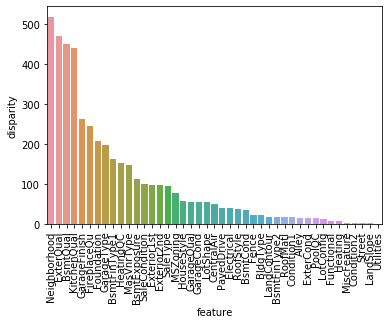

In [10]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(data0)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Here is quick estimation of influence of ***categorical*** variable on ***SalePrice***. For each variable ***SalePrices*** are partitioned to distinct sets based on category values. Then check with ***ANOVA** test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(data0, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


***Qualitative*** variables get encoded according to ordering based on mean of ***SalePrice***.

- **PoolQC:** Pool quality.

The data description shows that 'NA' means "No Pool", which makes sense. However, given the huge ratio of missing value ($>99\%$), the majority of houses have no Pool at all in general. So we choose to drop this variable as well as the variable **PoolArea**, which means the pool area in square feet.

In [12]:
PoolArea = data.PoolArea    # Save the 'PoolArea' column before drop it
PoolQC = data.PoolQC      
data = data.drop(['PoolArea','PoolQC'], axis=1)

- **MiscFeature:** Miscellaneous feature not covered in other categories.

The data description shows that 'NA' means "None", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [13]:
data["MiscFeature"] = data["MiscFeature"].fillna("None")

- **Alley:** Type of alley access to property.

The data description shows that 'NA' means "No alley access", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [14]:
data["Alley"] = data["Alley"].fillna("None")

- **Fence:** Fence quality.

The data description shows that 'NA' means "No Fence", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [15]:
data["Fence"] = data["Fence"].fillna("None")

- **FireplaceQu:** Fireplace quality.

The data description shows that 'NA' means "No Fireplace", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [16]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

- **LotFrontage:** Linear feet of street connected to property.

This is the numerical variable. Thus "NA" shows that these data are missed. Besides, the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we decide to fill in the missing data by the median **LotFrontage** of the neighborhood.

In [17]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond:** Garage Location, Interior finish of the Garage, Garage Quality and Garage Condition respectively.

The data description shows that 'NA' means "No Garage", which makes sense. And also, these are the categorical variables, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [18]:
for grg_cate in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[grg_cate] = data[grg_cate].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars:** Year Garage built, Size of Garage and Car Capacity of Garage respectively.

These three variables are numerical variables, while combined with other four variables shown before, we can know that here "NA" also means that there is no Garage. However, we can not replace "NA" with "None" due to the attribute of numeric. Here, we decide to fill in these data by 0, which also means that "No Garage".

In [19]:
for grg_num in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[grg_num] = data[grg_num].fillna(0)

##### 这里  感觉我们还要在考虑一下， 我搜了原来的train data
##### garageArea & Cars 的那两个变量  其实本身就是0
##### 但是 GarageYrBuilt 的那个 年份如果变成0的话
##### 别的都是19xx, 20xx 那如果这样考虑的话， 那会不会影响太大
##### 还是说考虑到这个变量的话，可能他的系数就很小，也没关系嘛？还是什么
##### 我在下面看到了year sold，把那个改成了categorical的了，我把这个也改了

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2:** Height of Basement, Condition of Basement, Walkout or Garden Level Walls, Rating of Basement Finished Area 1&2 respectively.

For all these categorical basement-related features, the data description shows that "NA" means "No Basement". We will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [20]:
for bsmt in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[bsmt] = data[bsmt].fillna('None')

- **MasVnrType and MasVnrArea:** Masonry Veneer Type and  Masonry Veneer Area.

In the data description, there is no "NA" type. Thus, we regard this as "None", since the corresponding variable **MasVnrArea** also shows "NA". And we will replace the latter variable with 0.

In [21]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

- **Electrical:** Electrical System.

It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [22]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [23]:
# Check if there still be any missing value

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(10)

Empty DataFrame
Columns: [Missing Ratio]
Index: []

- However, after dealing with some missing data, we need to process some numerical variables which actually are the categorical ones, such as **MSSubclass** (Identifies the type of dwelling involved in the sale.), **OverallQual** (the overall material and finish of the house), **OverallCond** (the overall condition of the house), **GarageYrBlt** (Year garage built),  **YrSold** (Year Sold) and **MoSold** (Month Sold)

In [24]:
data['MSSubClass'] = data['MSSubClass'].apply(str)

data['OverallCond'] = data['OverallCond'].astype(str)
data['OverallQual'] = data['OverallQual'].astype(str)

data['GarageYrBlt'] = data['GarageYrBlt'].astype(str)

data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [25]:
# Split the training data set and the test one.

train_data, test_data, train_SP, test_SP = train_test_split(data, SalePrice, test_size = 0.3)
print(train_data)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
855          20       RL         71.0     6897   Pave  None      IR1   
588          20       RL         65.0    25095   Pave  None      IR1   
180         160       FV         73.5     2117   Pave  None      Reg   
573          80       RL         76.0     9967   Pave  None      IR1   
971         160       RL         36.0     2268   Pave  None      Reg   
...         ...      ...          ...      ...    ...   ...      ...   
509          20       RL         80.0     9600   Pave  None      Reg   
1148         50       RM         60.0     5700   Pave  None      Reg   
1288        120       RL         40.0     5664   Pave  None      IR1   
484          20       RL         71.0     7758   Pave  None      IR1   
70           20       RL         95.0    13651   Pave  None      IR1   

     LandContour Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch  \
855          Lvl    AllPub    Corner  ...             0    

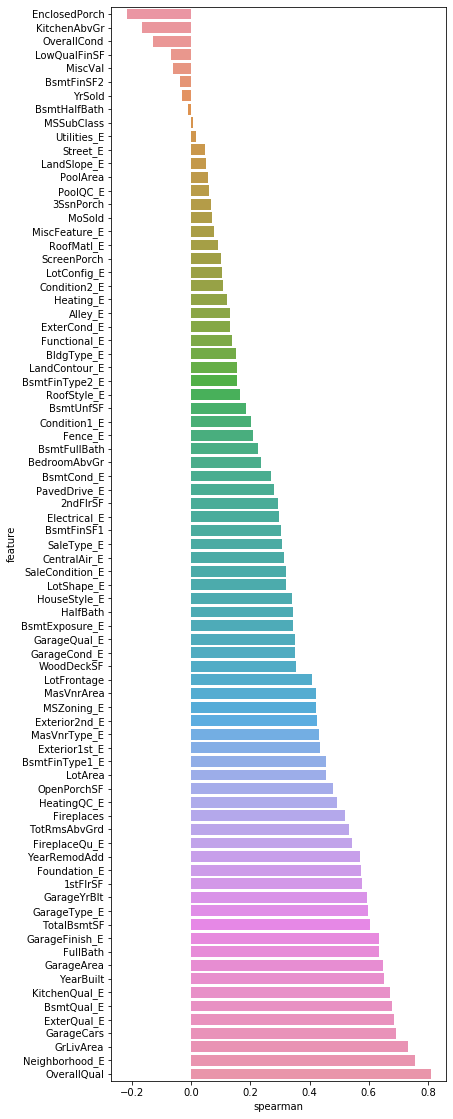

In [26]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = numerical + qual_encoded
spearman(data0, features)

***Spearman correlation*** is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

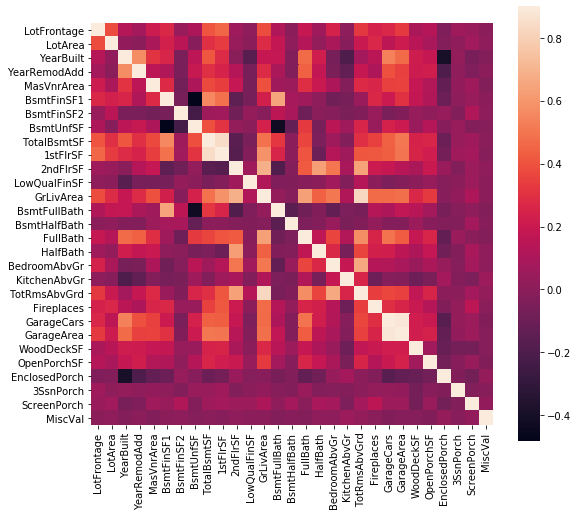

In [27]:
corrmat = train_data.corr()
plt.subplots(figsize=(9,8))
sns.heatmap(corrmat, vmax=0.9, square=True)

This is the correlation plot of numerical variables.

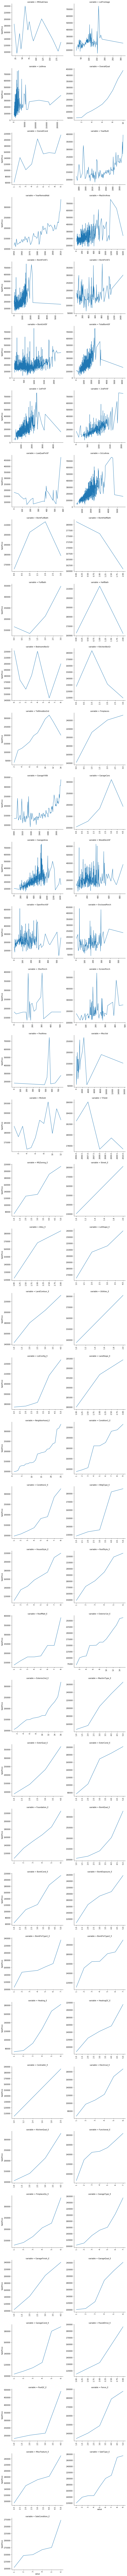

In [34]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(data0, id_vars=['SalePrice'], value_vars=numerical+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

- ***Clustering***

0.749494884242221


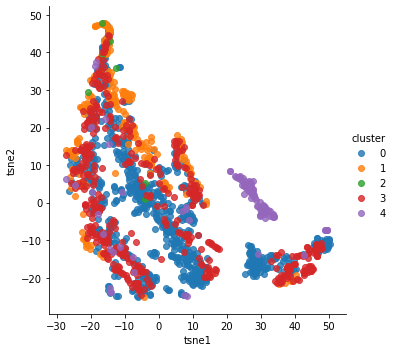

In [43]:
features = numerical + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = data0[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

30 First PCA Components explain 75% of variance. There seems to be some clustering present but it is not enough for segmented regression.

- ***Box-Cox transformation***

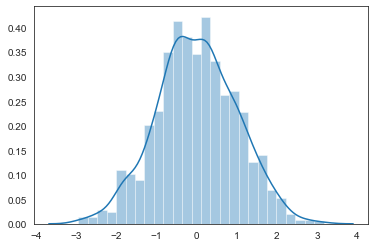

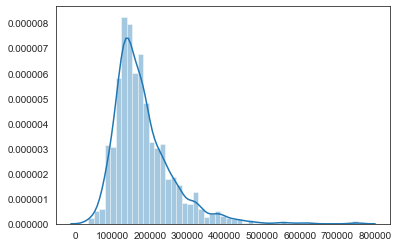

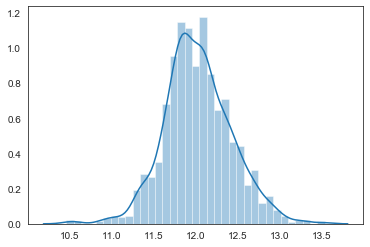

In [55]:
y = data0['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)

y1 = np.log1p(y)


yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)
plt.figure(3)
sns.distplot(y1)



Because the original y is not normal distributed, therefore we have to do transformation to it. We noticed that the Johnson transfromation and logrithm will transform it to normal distributed.